In [ ]:
import pandas as pd
import os
import glob
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


In [ ]:
def import_all_from_folder_as_df(directory_path: str) -> set:
  files = glob.glob(os.path.join(directory_path, "*.csv"))

  li = []

  for filename in files:
    df = pd.read_csv(filename, sep=";", index_col=None, header=0, on_bad_lines='skip')
    li.extend(df['sentence'].tolist())

  return li


In [ ]:
documents_list = import_all_from_folder_as_df("/content/csv")
print(len(documents_list))

328


In [ ]:
# Code adapted from https://www.datacamp.com/tutorial/discovering-hidden-topics-python
def retrieve_stopwords(path_to_stopwords: str) -> set:
  with open(path_to_stopwords, 'r') as file:
    lines = [line.strip() for line in file]
  return set(lines)

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = retrieve_stopwords("/content/stopwords/polish.stopwords.txt")
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        #stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel, doc_term_matrix

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


In [ ]:
number_of_topics=6
words=10
document_list = import_all_from_folder_as_df("../data/csv")
clean_text=preprocess_data(document_list)
model, dtm=create_gensim_lsa_model(clean_text,number_of_topics,words)


[(0, '0.496*"serca" + 0.415*"akcja" + 0.233*"ciśnienie" + 0.199*"nadciśnienie" + 0.185*"tętnicze" + 0.181*"minutę" + 0.164*"nocy" + 0.164*"dnia" + 0.145*"min" + 0.134*"abpm"'), (1, '-0.465*"choroby" + -0.380*"stan" + -0.325*"tętnicy" + -0.240*"lewej" + 0.205*"akcja" + 0.196*"serca" + -0.153*"tarczycy" + -0.126*"zwężenie" + 0.111*"ciśnienie" + -0.110*"nerek"'), (2, '-0.667*"choroby" + 0.345*"tętnicy" + 0.260*"lewej" + 0.234*"stan" + 0.144*"zwężenie" + -0.130*"nerek" + -0.129*"tarczycy" + 0.120*"udowej" + 0.117*"powierzchownej" + -0.112*"pokarmowego"'), (3, '-0.304*"tętnicy" + -0.254*"lewej" + -0.238*"serca" + 0.230*"nadciśnienie" + 0.227*"ahi" + 0.207*"tętnicze" + 0.191*"obs" + -0.180*"akcja" + -0.164*"choroby" + -0.145*"zwężenie"'), (4, '0.350*"stan" + -0.270*"obs" + 0.269*"tętnicze" + 0.268*"nadciśnienie" + -0.218*"psg" + -0.209*"ahi" + -0.194*"zlecam" + -0.187*"stwierdzono" + -0.187*"wykonanym" + -0.174*"protezowanie"'), (5, '0.264*"domowych" + 0.264*"pomiarach" + 0.263*"ciągu" + 0.2

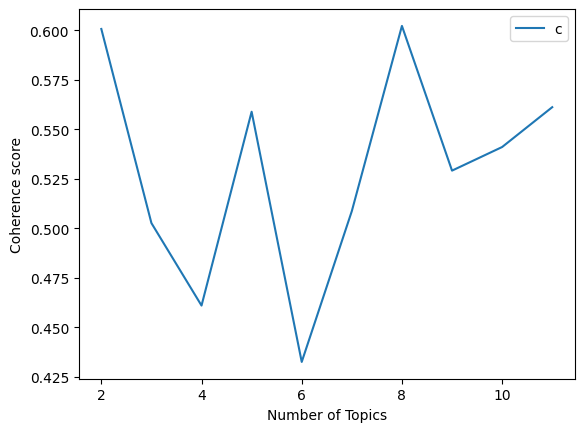

In [ ]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

In [ ]:
#model.show_topics(num_topics=6, num_words=10, log=False, formatted=True)

#all_doc_lsi_topics = model[dtm.]


mixture = [dict(model[x]) for x in dtm]
topics = pd.DataFrame(mixture)
topics['topic'] = topics.idxmax(axis=1)
topics["document"] = document_list
topics.to_csv("results.csv")
print(dtm[0])
#all_doc_lsi_topics[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [ ]:
clean_text[0]

['stanie',
 'wejść',
 'aktualnie',
 'ii',
 'piętro',
 'dolegliwości',
 'bólowych',
 'dzisiejszym',
 'badaniu',
 'fizykalnym',
 'płuca',
 'osłuchowo',
 'zmian',
 'obrzęki']

In [ ]:
joined_ct = " ".join([
    x
    for xs in clean_text
    for x in xs
])


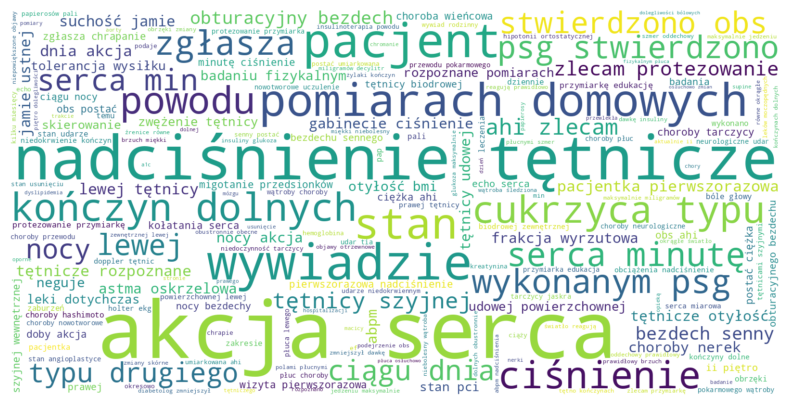

In [ ]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Create a word cloud object
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(joined_ct)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('/content/wordcloud.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')